# Data Pre-Processing

In [6]:
import pandas as pd
import json
import re
import numpy as np
from collections import Counter
import string
from nltk.tokenize import RegexpTokenizer,TweetTokenizer

In [2]:
import os
import pickle
os.getcwd()
data_location="/home/ubuntu/data/"

Read data

In [29]:
col_names=['tag','id','date','query','user','text']
df_train=pd.read_csv('/home/ubuntu/data/training.1600000.processed.noemoticon.csv',
                  names=col_names, header=None)

Check what data looks like

In [30]:
df_train.head()

,tag,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Check data distribution

In [13]:
df_train.groupby(['tag']).size()

tag
0    800000
4    800000
dtype: int64

Check test data

In [3]:
col_names=['tag','id','date','query','user','text']
df_test=pd.read_csv('/home/ubuntu/data/testdata.manual.2009.06.14.csv',names=col_names, header=None)
df_test.groupby(['tag']).size()
print(len(df_test))

498


In [4]:
df_test.head()

,tag,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [9]:
df_train.to_pickle("/home/ubuntu/data/train_dataframe.pkl")

In [3]:
df_train=pd.read_pickle("/home/ubuntu/data/train_dataframe.pkl")

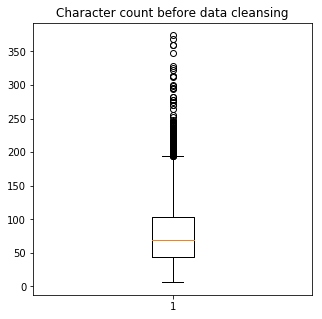

In [12]:
import matplotlib.pyplot as plt
df_train['len'] = [len(t) for t in df_train.text]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_train.len)
plt.title('Character count before data cleansing')
plt.show()

Data Cleansing:
1. Remove Hyperlinks, unrecognised encodings
2. Remove '...' and '..'
2. Remove hashtag signs 
3. Remove UTF-8 BOM (Byte Order Mark)
4. Tokenize, strip html encoding, Remove @user using Nltk's TweetTokenizer 
5. Remove punctuations (but not smiley faces etc.) 

In [7]:
tweet_tokenizer=TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def tweet_cleaner(sentence):
    sentence=re.sub(r'https?://[A-Za-z0-9./]+|www.[A-Za-z0-9./]+|[\x80-\xFF]+','',sentence)
    sentence2=re.sub(r'[..]|[...]',' ',sentence)
    sentence3=sentence2.replace('#','').lower()
    
    try:
        sentence4 = sentence3.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        sentence4 = sentence3 
    tokenized=tweet_tokenizer.tokenize(sentence4)
    joined=' '.join(c for c in tokenized if c not in string.punctuation)
    return joined

In [294]:
num=[0,1600000]
clean_texts=[]
for i in xrange(num[0],num[1]):
    if( (i+1)%100000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, num[1] )) 
    clean_texts.append(tweet_cleaner(df_train['text'][i]))

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed


In [295]:
df_train_clean=pd.DataFrame(clean_texts,columns=['cleaned_text'])
df_train_clean['tag']=df_train.tag

In [296]:
df_train_clean.head()

,cleaned_text,tag
0,awww that's a bummer you shoulda got david car...,0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it's not behaving at all i'm mad why am i h...,0


Check the lens of the tweets and see if there are any anomalies - Added the following: 
1. Remove characters that are failed to encode: [\x80-\xFF] these are non-english characters. 
2. Remove '..' and '...' as they are not informative in reading the sentiment of a tweet

In [297]:
long_text_list=[x for x in clean_texts if len(x)>140]
len(long_text_list)
#long_text_list[275:284]

1

In [298]:
long_text_list

[u'coke can in car --> 90f --> can burst --> coke all over --> procrastintd cleaning --> thgt will evaporate --> 2 days later --> turned syrupy --> stinks']

In [308]:
df_train_clean['len'] = [len(t) for t in df_train_clean.cleaned_text]

Plot distribution of words

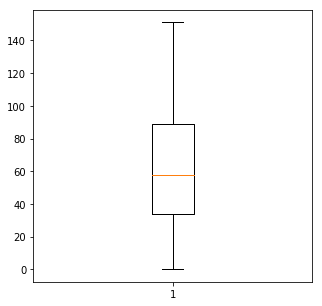

In [302]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_train_clean.len)
plt.show()

Get Rid of Tweets with no content

In [304]:
no_text_list=[x for x in clean_texts if len(x)==0]
len(no_text_list)

3600

In [307]:
df_train_clean2=df_train_clean[df_train_clean.len!=0]
df_train_clean2.to_pickle("/home/ubuntu/data/train_cleaned.pkl")

# Vectorize tokens - Doc2Vec and Pre-trained GloVe Twitter Embedding

In [10]:
df_train_cleaned=pd.read_pickle("/home/ubuntu/data/train_cleaned.pkl")
df_train_cleaned=df_train_cleaned.reset_index(drop=True)
df_train_cleaned.tail()

,cleaned_text,tag,len
1596395,just woke up having no school is the best feel...,4,54
1596396,thewdb com very cool to hear old walt intervie...,4,54
1596397,are you ready for your mojo makeover ask me fo...,4,55
1596398,happy 38th birthday to my boo of alll time tup...,4,61
1596399,happy charitytuesday,4,20


In [13]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, Doc2Vec
import gensim
from sklearn.decomposition import PCA
from matplotlib import pyplot
import multiprocessing

#1. Make Corpus

Train Validation Test Split

In [12]:
x_train, x_validation_test, y_train, y_validation_test=train_test_split(df_train_cleaned.cleaned_text, df_train_cleaned.tag, test_size=0.2, random_state=42)
x_validation, x_test, y_validation, y_test=train_test_split(x_validation_test, y_validation_test, test_size=0.5,random_state=42)
print('train, validation, test size: %d, %d, %d' % (len(x_train), len(x_validation), len(x_test)))
print('tag distribution on train set: %s' % Counter(y_train).values())

train, validation, test size: 1277120, 159640, 159640
tag distribution on train set: [639355, 637765]


In [20]:
Counter(y_test).values()

[79473, 80167]

In [51]:
def save_data(save_path, file_name, data):
    with open(save_path+file_name,'wb') as f:
        pickle.dump(data,f)


In [10]:
all_x=pd.concat([x_train,x_validation, x_test])
all_y=pd.concat([y_train,y_validation,y_test])

Split words in tweets and label each tweet. words that form one tweet convey a particular semantic meaning. 

In [14]:
corpus=[]
for tweet, index in zip(all_x, all_x.index.values):
    a=gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(tweet),[index])
    corpus.append(a)    
print(corpus[:10])


[TaggedDocument(words=[u'oh', u'didn', u'check', u'twitter', u'it', u'was', u'your', u'birthday', u'rob', u'sorry', u'happy', u'birthdaaay', u'hope', u'you', u'are', u'fit', u'very', u'soon', u'again', u'to', u'win', u'races'], tags=[782531]), TaggedDocument(words=[u'hey', u'you', u'there', u'what', u'up'], tags=[851032]), TaggedDocument(words=[u'listening', u'to', u'david', u'on', u'magic'], tags=[935532]), TaggedDocument(words=[u'it', u'the', u'load', u'with', u'all', u'the', u'boxes', u'of', u'stuff', u'from', u'the', u'attic', u'of', u'all', u'your', u'previous', u'houses'], tags=[830487]), TaggedDocument(words=[u'homeeesie', u'back', u'to', u'being', u'lonely', u'in', u'sd', u'having', u'only', u'my', u'collection', u'of', u'hello', u'kittys', u'to', u'cuddle', u'up', u'with'], tags=[94010]), TaggedDocument(words=[u'eat', u'sleep', u'draw', u'part', u'of', u'my', u'neuroanatomy', u'take', u'home', u'test', u'after', u'this', u'im', u'part', u'of', u'my', u'neuro'], tags=[905841]),

In [28]:
with open(data_location + 'tokenized_corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [11]:
with open(data_location + 'tokenized_corpus.pkl', 'rb') as f:
    corpus=pickle.load(f)

#2. Build Model and load vectors

In [ ]:
model_location="/home/ubuntu/model/"
cores = multiprocessing.cpu_count()

In [ ]:
embedding_model1=Doc2Vec(dm=0, vector_size=200, negative=5, min_count=2, epochs=20,workers=cores)
embedding_model1.build_vocab(corpus)
embedding_model1.train(corpus,total_examples=embedding_model1.corpus_count,epochs=embedding_model1.epochs)

In [17]:
embedding_model1.save(model_location + 'embedding_model1')

In [15]:
embedding_model1 = Doc2Vec.load(model_location + 'embedding_model1')

Check how good the model is doing - find the most , median and least similar tweets. Seems good!

In [93]:
import random

doc_id = np.random.randint(embedding_model1.docvecs.count)  # pick random doc, re-run cell for more examples
sims = embedding_model1.docvecs.most_similar(doc_id, topn=embedding_model1.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): «%s»\n' % (doc_id, ''.join(all_x[doc_id])))

TARGET (930782): «i need more coffee and redbull»



In [94]:
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % embedding_model1)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ''.join(all_x[sims[index][0]])))

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dbow,d200,n5,mc2,s0.001,t4):

MOST (347553, 0.9487342834472656): «need more coffee»

MEDIAN (695446, 0.38756710290908813): «feeels sick after eating cinema sweet popcorn without the cinema»

LEAST (693079, -0.23393338918685913): «7k5»



#Save train/test/validation data and load

In [ ]:
tostore=dict(zip(['X_train', 'X_validation', 'X_test', 'y_train', 'y_validation', 'y_test' ], 
                 [x_train, x_validation, x_test, y_train, y_validation, y_test]))
save_data(data_location,'train_val_test.pkl',tostore)

In [18]:
def get_vectors(model, data, vector_size):
    vecs = np.zeros((len(data), vector_size)) 
    v=0
    for i in data.index:
        vecs[v]=model.docvecs[i]
        v+=1
    return vecs
                

In [26]:
with open (data_location+'train_val_test.pkl', 'rb') as file:
    dict_data=pickle.load(file)

In [27]:
x_train=dict_data['X_train']
x_validation=dict_data['X_validation']
x_test=dict_data['X_test']
y_train=dict_data['y_train']
y_validation=dict_data['y_validation']
y_test=dict_data['y_test']

In [19]:
%time
x_train_v=get_vectors(embedding_model1,x_train,200)
x_validation_v=get_vectors(embedding_model1,x_validation,200)
x_test_v=get_vectors(embedding_model1,x_test,200)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


In [24]:
vocab_size=len(embedding_model1.wv.vocab)
print(vocab_size)

104193


#Using Pre-trained Glove embedding

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [6]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

In [9]:
with open(model_location+'glove_embedding.pkl', 'wb') as file:
    pickle.dump(glove_twitter, file)

In [15]:
with open(model_location+'glove_embedding.pkl', 'rb') as file:
    glove_twitter=pickle.load(file)

In [10]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [16]:
from sklearn.preprocessing import scale
train_vecs_glove_mean = scale(np.concatenate([get_w2v_general(t, 200, glove_twitter,'mean') for t in x_train]))
validation_vecs_glove_mean = scale(np.concatenate([get_w2v_general(t, 200, glove_twitter,'mean') for t in x_validation]))

In [18]:
test_vecs_glove_mean = scale(np.concatenate([get_w2v_general(t, 200, glove_twitter,'mean') for t in x_test]))

#Use word-level vectors 

In [28]:
all_x=pd.concat([x_train,x_validation, x_test])
all_y=pd.concat([y_train,y_validation,y_test])

In [32]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_x)
data = tokenizer.texts_to_sequences(all_x)

In [69]:
#an example of the padded data for illustration
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_x[:1000])
data = tokenizer.texts_to_sequences(all_x[:1000])
padded_data = pad_sequences(data, maxlen=40)
padded_data[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   56,    1, 1098,  673,  156,  116,
           8,   25,   52,  302, 1099,  163,  136, 1100,   78,    7,   39,
        1101,   92,  164,  130,    2,  226,  674],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  137,    7,   61,  505,   32],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         506,    2,  303,   14,  675, 1102,  201],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   46,    3,  676,  

#check word count distribution

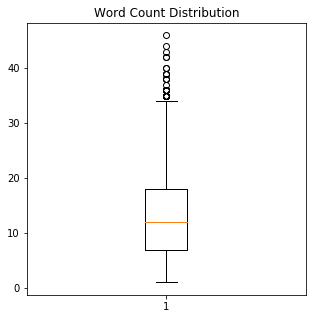

In [29]:
import matplotlib.pyplot as plt
word_counts=[]
for i in all_x:
    word_count=len(i.split())
    word_counts.append(word_count)
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(word_counts)
plt.title('Word Count Distribution')
plt.show()

In [64]:
from keras.utils.np_utils import to_categorical
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

padded_data = pad_sequences(data, maxlen=40)

labels = to_categorical(all_y.replace(4,1),2)

# split the data into a training set and a validation set
#indices = np.arange(data.shape[0])
# indices = np.arange(len(data))
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(0.8 * data.shape[0])
split_idx = int(len(padded_data)*0.8)
train_x, val_x = padded_data[:split_idx], padded_data[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

Found 282800 unique tokens.


In [34]:
EMBEDDING_DIM=200
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
#for i, (word, info) in enumerate(embedding_model1.wv.vocab.items()):
for word, i in word_index.items():
    try:
        embedding_vector = glove_twitter.get_vector(word)
    except KeyError:
        continue        
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
count=0
for i in embedding_matrix:
    if np.any(i)==True:
        count+=1
print('percentage tokens vectorised, {:0.2f}{}'.format(100*float(count)/float(len(word_index)),'%'))

percentage tokens vectorised, 44.03%


#Pre-trained GloVe 200 Logistic Regression 

In [61]:
from sklearn.metrics import roc_curve, auc
from copy import deepcopy
import numpy as np
import pickle
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from contextlib import contextmanager

import os
from os.path import dirname, realpath
import sys

# Change to current path
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2



def plot_roc(fpr, tpr, roc_auc, show_plot =False):
    """
        plot the roc curve with given information

        Args:
        --------
            fpr: false positive rate
            tpr: true positive rate
            roc_auc: area under the roc curve
            show_plot: set to True to show the plot, False to not show the plot

        Returns:
        --------
            Graphic handle, represents the roc curve plot
    """
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc Curve')
    plt.legend(loc="lower right")
    if show_plot:
        plt.show()
    return plt.gcf()

In [102]:
clf = LogisticRegression()
clf.fit(train_vecs_glove_mean, y_train.replace(4,1))
print clf.score(validation_vecs_glove_mean, y_validation.replace(4,1))

0.7614507642194939


In [103]:
y_pred=clf.predict(scale(np.concatenate([get_w2v_general(t, 200, glove_twitter,'mean') for t in x_test])))
print(classification_report(y_pred, y_test.replace(4,1)))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76     80040
          1       0.76      0.76      0.76     79600

avg / total       0.76      0.76      0.76    159640



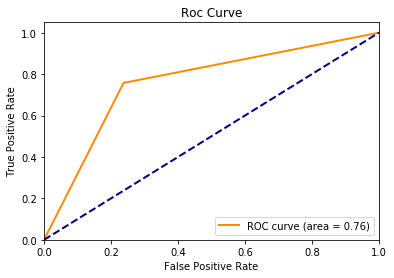

In [104]:
fpr, tpr, thr = roc_curve(y_score=y_pred, y_true=y_test.replace(4,1),pos_label=1)
roc_auc = auc(fpr, tpr)
plt.cla()
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

In [105]:
log_model_path = '/home/ubuntu/model/logistic_regression.h5'
pickle.dump(clf, open(log_model_path, 'wb'))

#Doc2Vec logistic Regression and Linear SVM

In [21]:
clf_doc2vec = LogisticRegression()
clf_doc2vec.fit(x_train_v, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print(clf_doc2vec.score(x_validation_v, y_validation))
y_pred=clf_doc2vec.predict(x_test_v)
print(classification_report(y_pred, y_test))

0.745107742420446
             precision    recall  f1-score   support

          0       0.74      0.75      0.74     78472
          4       0.75      0.74      0.75     81168

avg / total       0.75      0.75      0.75    159640



In [23]:
clf_svm=LinearSVC()
print('fit')
%time
clf_svm.fit(x_train_v, y_train)
print('validate')
print(clf_svm.score(x_validation_v, y_validation))
#y_pred=clf_svm.predict(x_test_v)
#print('test',classification_report(y_pred, y_test))

fit
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
validate
0.7449887246304184


In [36]:
y_pred=clf_svm.predict(x_test_v)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.73      0.75      0.74     78219
          4       0.75      0.74      0.75     81421

avg / total       0.74      0.74      0.74    159640



# Build Neural Networks 

In [25]:
from keras import backend as K
from keras.models import Model
from keras import callbacks
from keras.layers import (Conv1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout, Input, Flatten,
    TimeDistributed, Activation, GRU, LSTM, Embedding)
#from gensim.models import Word2Vec
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#Pre-Trained GloVe sentene level vector with LSTM

In [64]:
vector_size=200
#max_feature=len(embedding_model1.wv.vocab)+1
max_feature=len(glove_twitter.wv.vocab)+1
lstm_units=128

def lstm(max_features, lstm_units, output_dim=2):
    model = Sequential()
    #model.add(Embedding(max_features, embed_dim))
    model.add(LSTM(lstm_units, input_dim=200, return_sequences=False, dropout=0.2))
#     model.add(BatchNormalization(axis=-1,
#                             momentum=0.99,
#                             epsilon=0.001,
#                             center=True,
#                             scale=True,
#                             beta_initializer='zeros',
#                             gamma_initializer='ones',
#                             moving_mean_initializer='zeros',
#                             moving_variance_initializer='ones',
#                             beta_regularizer=None,
#                             gamma_regularizer=None,
#                             beta_constraint=None,
#                             gamma_constraint=None))
    model.add(Dense(output_dim, activation='sigmoid'))
    optimizer=Adam(lr=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
model=lstm(max_features=max_feature, lstm_units=lstm_units, output_dim=2)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=False, dropout=0.2, input_shape=(None, 200...)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 168,706
Trainable params: 168,706
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
batch_size = 32
learning_rate=.01

fname = '/home/ubuntu/model/keras-lstm.h5'
cbks = [callbacks.ModelCheckpoint(filepath=fname, monitor='val_loss', save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=2)]

hist = model.fit(x=train_vecs_glove_mean.reshape(len(train_vecs_glove_mean),1,200), y=to_categorical(y_train.replace(4,1),2), 
    batch_size=batch_size, epochs=20,
    verbose=1,
    callbacks=cbks,
#     validation_split=0.8,
    validation_data=(validation_vecs_glove_mean.reshape(len(validation_vecs_glove_mean),1,200), to_categorical(y_validation.replace(4,1),2)),
    shuffle=True,
    class_weight=None,
    sample_weight=None)

with open('/home/ubuntu/model/lstm.pickle', 'wb') as f:
    pickle.dump(hist.history, f)

Train on 1277120 samples, validate on 159640 samples
Epoch 1/20
1277120/1277120 [==============================] - 269s - loss: 0.4622 - acc: 0.7782 - val_loss: 0.4500 - val_acc: 0.7861
Epoch 2/20
1277120/1277120 [==============================] - 270s - loss: 0.4579 - acc: 0.7806 - val_loss: 0.4490 - val_acc: 0.7865
Epoch 3/20
1277120/1277120 [==============================] - 270s - loss: 0.4563 - acc: 0.7819 - val_loss: 0.4478 - val_acc: 0.7872
Epoch 4/20
1277120/1277120 [==============================] - 270s - loss: 0.4547 - acc: 0.7828 - val_loss: 0.4475 - val_acc: 0.7868
Epoch 5/20
1277120/1277120 [==============================] - 269s - loss: 0.4539 - acc: 0.7831 - val_loss: 0.4474 - val_acc: 0.7874
Epoch 6/20
1277120/1277120 [==============================] - 268s - loss: 0.4528 - acc: 0.7837 - val_loss: 0.4471 - val_acc: 0.7881
Epoch 7/20
1277120/1277120 [==============================] - 268s - loss: 0.4524 - acc: 0.7840 - val_loss: 0.4468 - val_acc: 0.7877
Epoch 8/20
12771

In [71]:
y_pred=model.predict(test_vecs_glove_mean.reshape(len(test_vecs_glove_mean),1,200))

In [91]:
# just pick whichever prob is higher as prediction
y_pred_class=(y_pred == y_pred.max(axis=1, keepdims=True)).astype(int)
#pred_1_click_train=pred_click_train[:,1]
y_pred_class=y_pred_class[:,1]

In [92]:
print(classification_report(y_pred_class, y_test.replace(4,1)))

             precision    recall  f1-score   support

          0       0.80      0.78      0.79     81096
          1       0.78      0.79      0.79     78544

avg / total       0.79      0.79      0.79    159640



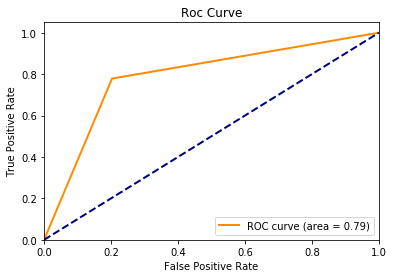

In [101]:
fpr, tpr, thr = roc_curve(y_score=y_pred_class, y_true=y_test.replace(4,1),pos_label=1)
roc_auc = auc(fpr, tpr)
plt.cla()
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

#Pre-trained Glove, word level vector with LSTM

In [80]:
embed_dim=200
#max_feature=len(embedding_model1.wv.vocab)+1
max_feature=len(word_index)+1
lstm_units=128

def lstm(max_features, lstm_units, output_dim=2):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], mask_zero=True))
    model.add(LSTM(lstm_units, input_shape=(None,200), return_sequences=False, dropout=0.2))
    model.add(BatchNormalization(axis=-1,
                            momentum=0.99,
                            epsilon=0.001,
                            center=True,
                            scale=True,
                            beta_initializer='zeros',
                            gamma_initializer='ones',
                            moving_mean_initializer='zeros',
                            moving_variance_initializer='ones',
                            beta_regularizer=None,
                            gamma_regularizer=None,
                            beta_constraint=None,
                            gamma_constraint=None))
    model.add(Dense(output_dim, activation='sigmoid'))
    optimizer=Adam(lr=0.01)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model

In [81]:
model3=lstm(max_features=max_feature, lstm_units=lstm_units, output_dim=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 200)         56560200  
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               168448    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 56,729,418
Trainable params: 56,729,162
Non-trainable params: 256
_________________________________________________________________
None


In [ ]:
batch_size = 64
learning_rate=.01

fname = '/home/ubuntu/model/keras-lstm-word_2.h5'
cbks = [callbacks.ModelCheckpoint(filepath=fname, monitor='val_loss', save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=2)]

hist = model3.fit(x=train_x, y=train_y, 
    batch_size=batch_size, epochs=20,
    verbose=1,
    callbacks=cbks,
#     validation_split=0.8,
    validation_data=(val_x, val_y),
    shuffle=True,
    class_weight=None,
    sample_weight=None)

with open('/home/ubuntu/model/lstm_word_2.pickle', 'wb') as f:
    pickle.dump(hist.history, f)

y_pred=model3.predict(test_x)
# just pick whichever prob is higher as prediction
y_pred_class=(y_pred == y_pred.max(axis=1, keepdims=True)).astype(int)
#pred_1_click_train=pred_click_train[:,1]
y_pred_class=y_pred_class[:,1]
print(classification_report(y_pred_class, test_y[:,1]))

Train on 1277120 samples, validate on 159640 samples
Epoch 1/20
1277120/1277120 [==============================] - 4728s - loss: 0.4385 - acc: 0.7982 - val_loss: 0.4436 - val_acc: 0.7946
Epoch 3/20
1277120/1277120 [==============================] - 4717s - loss: 0.4375 - acc: 0.7993 - val_loss: 0.4481 - val_acc: 0.7923
Epoch 4/20
1277120/1277120 [==============================] - 4706s - loss: 0.4370 - acc: 0.8001 - val_loss: 0.4477 - val_acc: 0.7934
             precision    recall  f1-score   support

          0       0.81      0.78      0.79     82460
          1       0.77      0.80      0.79     77180

avg / total       0.79      0.79      0.79    159640



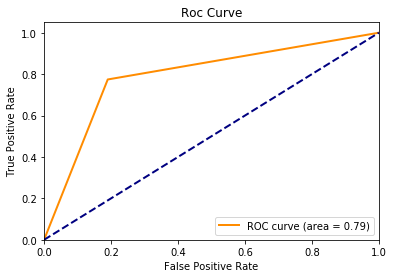

In [83]:
fpr, tpr, thr = roc_curve(y_score=y_pred_class, y_true=test_y[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.cla()
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

#Doc2Vec with CNN/Simple NN

In [28]:
input_dim=200
output_dim=2
model = Sequential()
# model.add(Conv1D(activation="relu", input_shape=(1, input_dim), 
#                  filters=128, kernel_size=1, padding="same", 
#                  kernel_initializer="lecun_uniform"))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling1D())
model.add(Dense(64, input_dim=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
optimizer=Adam(lr=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                12864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total para

In [ ]:
#seed=7
filepath=fname = '/home/ubuntu/model/keras-doc2vec.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=3, mode='max') 
callbacks_list = [checkpoint, early_stop]
#np.random.seed(seed)
history = model.fit(x_train_v, to_categorical(y_train.replace(4,1),2), 
                                batch_size=64, epochs=20,
                                #validation_split=0.1,
                                validation_data=(x_validation_v, to_categorical(y_validation.replace(4,1),2)),
                                shuffle=False,
                                #class_weight=self.train_class_weight,
                                callbacks=[checkpoint, early_stop],
                                verbose=1  # 0 silent, 1 verbose, 2 one log line per epoch
                                )

Train on 1277120 samples, validate on 159640 samples
Epoch 1/20
1277120/1277120 [==============================] - 138s - loss: 0.5030 - acc: 0.7552 - val_loss: 0.4826 - val_acc: 0.7661
Epoch 2/20
1277120/1277120 [==============================] - 136s - loss: 0.4888 - acc: 0.7637 - val_loss: 0.4784 - val_acc: 0.7700
Epoch 3/20
1277120/1277120 [==============================] - 137s - loss: 0.4842 - acc: 0.7663 - val_loss: 0.4722 - val_acc: 0.7731
Epoch 4/20
1277120/1277120 [==============================] - 137s - loss: 0.4816 - acc: 0.7679 - val_loss: 0.4697 - val_acc: 0.7743
Epoch 5/20
1277120/1277120 [==============================] - 137s - loss: 0.4802 - acc: 0.7688 - val_loss: 0.4682 - val_acc: 0.7748
Epoch 6/20
1277120/1277120 [==============================] - 137s - loss: 0.4786 - acc: 0.7698 - val_loss: 0.4674 - val_acc: 0.7755
Epoch 7/20
1277120/1277120 [==============================] - 137s - loss: 0.4773 - acc: 0.7707 - val_loss: 0.4680 - val_acc: 0.7758
Epoch 8/20
12771

In [36]:
with open('/home/ubuntu/model/doc2vec.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [34]:
y_pred=model.predict(x_test_v)
# just pick whichever prob is higher as prediction
y_pred_class=(y_pred == y_pred.max(axis=1, keepdims=True)).astype(int)
#pred_1_click_train=pred_click_train[:,1]
y_pred_class=y_pred_class[:,1]
print(classification_report(y_pred_class, y_test.replace(4,1)))
#print(Accuracy_score(y_pred_class, y_test))

             precision    recall  f1-score   support

          0       0.80      0.76      0.78     83157
          1       0.76      0.79      0.77     76483

avg / total       0.78      0.78      0.78    159640



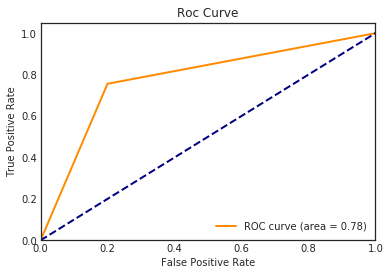

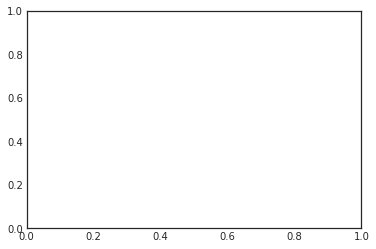

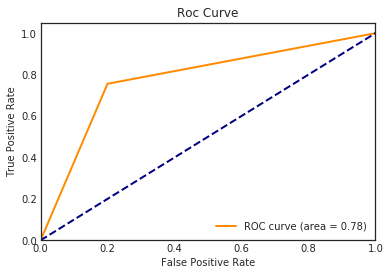

In [65]:
fpr, tpr, thr = roc_curve(y_score=y_pred_class, y_true=y_test.replace(4,1),pos_label=1)
roc_auc = auc(fpr, tpr)
plt.cla()
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

#model training and validation loss performance

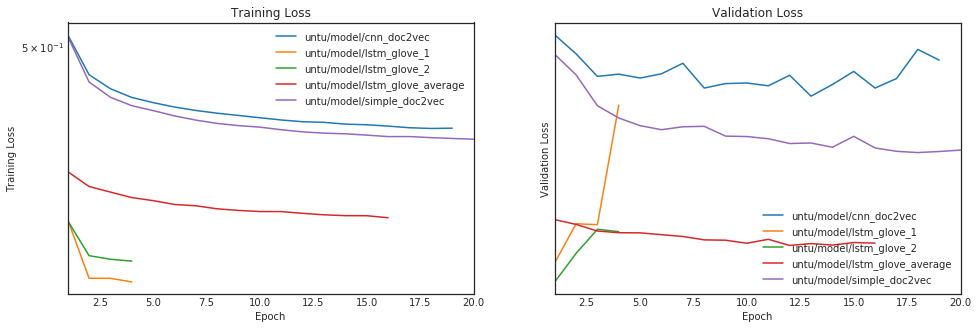

In [43]:
from glob import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("/home/ubuntu/model/*.pickle"))

# all_pickles.remove('results/model_0.pickle')

# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')

plt.semilogy()

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.semilogy()
plt.show()

# Benchmark Model - Tf-Idf vectorisation and Logistics/Linear SVM 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import PredefinedSplit,GridSearchCV
import time
from scipy.sparse import coo_matrix, vstack

In [13]:
max_features=len(embedding_model1.wv.vocab)

In [26]:
max_features

104193

In [133]:
def train_test(pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test):
    model=pipeline.fit(x_train,y_train)
    print(model.score(x_validation, y_validation))
    %time
    y_pred=model.predict(x_test)
    print(classification_report(y_test, y_pred))

In [30]:
tfidf_vec = TfidfVectorizer(max_features=max_features,ngram_range=(1, 3))
pipeline = Pipeline(steps=[
        ('vectorizer', tfidf_vec),
        ('dim_red',TruncatedSVD(n_components=200, random_state=42)),
        ('classifier', LogisticRegression(verbose=1)),
         ])
train_test(pipeline, x_train, y_train, x_validation, y_validation, x_test, y_test)

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[LibLinear]0.7041718867451766
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs
             precision    recall  f1-score   support

          0       0.69      0.71      0.70     77977
          4       0.72      0.70      0.71     81663

avg / total       0.70      0.70      0.70    159640



In [43]:
def tf_idf(x, vector, is_test=False):
    if is_test==True:
        x_vec=vector.transform(x)
    else:
        x_vec=vector.fit_transform(x)
    return x_vec

In [116]:
X_=[]
for i in range(len(x_train)):
    X_.append(x_train.values[i])
for t in range(len(x_validation)):
    X_.append(x_validation.values[t])

In [123]:
Y_=[]
for i in range(len(y_train)):
    Y_.append(y_train.values[i])
for t in range(len(y_validation)):
    Y_.append(y_validation.values[t])

In [124]:
tfidf_vec = TfidfVectorizer(max_features=max_features,ngram_range=(1, 3))
X_tfidf=tf_idf(X_, tfidf_vec)

In [135]:
x_test_tfidf=tf_idf(x_test,tfidf_vec, is_test=True)

In [126]:
pipeline = Pipeline(steps=[
        ('reduce_dim',TruncatedSVD()),
        ('classifier', LogisticRegression(verbose=1)),
         ])

N_FEATURES_OPTIONS = [100, 200]
param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        #'classifier__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        #'classifier__C': C_OPTIONS
    },
]
reducer_labels = ['TruncatedSVD', 'KBest(chi2)']

# train_ind=np.zeros(len(x_train))
# val_ind=np.zeros(len(x_validation))
# for i in range(len(x_train)):
#     train_ind[i] = -1

# for i in range(len(x_validation)):
#     val_ind[i] = 0

# ps = PredefinedSplit(test_fold=np.concatenate((train_ind,val_ind)))
#X=vstack([x_train_tfidf,x_validation_tfidf])
#Y=np.concatenate([np.array(y_train), np.array(y_validation)])


print('Fit data...')
grid = GridSearchCV(pipeline, #cv=ps, 
                    n_jobs=2, param_grid=param_grid)
grid.fit(X_tfidf, Y_)

Fit data...
[LibLinear]

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'reduce_dim': [TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=None, tol=0.0)], 'reduce_dim__n_components': [100, 200]}, {'reduce_dim': [SelectKBest(k=10, score_func=<function chi2 at 0x7feb3dd87cf8>)], 'reduce_dim__k': [100, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [127]:
print('Optimal alpha parameter: {:}'.format(grid.best_params_))
print('Best score (on validation data): {:0.2f}'.format(grid.best_score_))

Optimal alpha parameter: {'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=None, tol=0.0), 'reduce_dim__n_components': 200}
Best score (on validation data): 0.74


In [136]:
y_pred=grid.predict(x_test_tfidf)
print(classification_report(y_true=y_test, y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.74      0.72      0.73     79473
          4       0.73      0.75      0.74     80167

avg / total       0.74      0.74      0.74    159640



In [137]:
log_model_path = '/home/ubuntu/model/logistic_regression_tfidf.h5'
pickle.dump(grid, open(log_model_path, 'wb'))